In [1]:
import os
import sys
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import math
from tqdm.notebook import tqdm_notebook

import import_ipynb
from Reservoir import Reservoir
from Trainer import Trainer
from Model import Model

importing Jupyter notebook from Reservoir.ipynb
importing Jupyter notebook from Trainer.ipynb
importing Jupyter notebook from Model.ipynb


In [2]:
torch.cuda.empty_cache()

In [3]:
class Tester():
    def __init__(self):
        self.dataset = Reservoir("./data/training/images/train-images-idx3-ubyte.gz",
                        "./data/training/labels/train-labels-idx1-ubyte.gz",
                        "./data/testing/images/t10k-images-idx3-ubyte.gz",
                        "./data/testing/labels/t10k-labels-idx1-ubyte.gz")
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print('using device', self.device)
        image_shape = self.dataset.training_pool[0]['image'].shape
        print("Data size", len(self.dataset.training_pool))
        self.model = Model(self.device)
        
        print("number of parameters: ", sum(p.numel() for p in self.model.network.parameters()))
        
        
    
    def run_training(self,epochs, snapshot=""):
        report_period = 100
        
        trainer = Trainer(self.model, self.dataset)
        self.model = trainer.fit(epochs, report_period, snapshot)
        
    def test_accuracy(self):
        total = 0
        correct = 0

        self.model.network.eval()

        for i, batch in enumerate(self.dataset.testing_pool.testloader):
            image = batch['image'][0].float()
            image = image.reshape(1,1,28,28).to(self.device).float()
            label = batch['label'][0]
            output = torch.argmax(self.model.network(image))

            if output.item() == label.item():
                correct += 1
            total += 1

        print("Total: "+str(total))
        print("Correct: "+str(correct))

        print("Percent Correct: {}%".format((correct/total)*100))

Total training stacks 5400
Total validation stacks 600
Total testing stacks 10000
using device cpu
Data size 60000
units after conv 588
fc parameters:  5890
number of parameters:  5926



Epoch: 9
Training Loss: 0.14689
Validation Loss: 0.11932


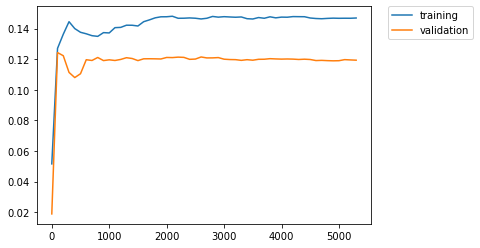


Epoch: 10
Training Loss: 0.14677
Validation Loss: 0.11952


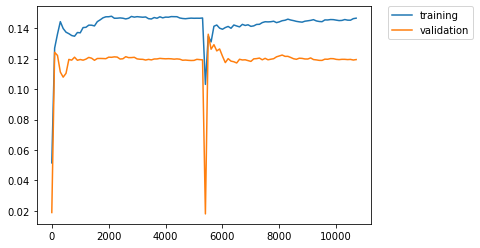


Epoch: 11
Training Loss: 0.14627
Validation Loss: 0.11864


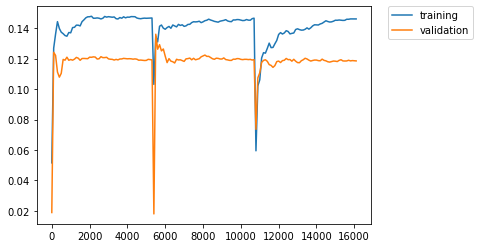


Epoch: 12
Training Loss: 0.14688
Validation Loss: 0.1194


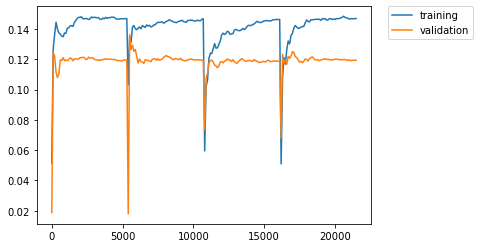


Epoch: 13
Training Loss: 0.14721
Validation Loss: 0.11821


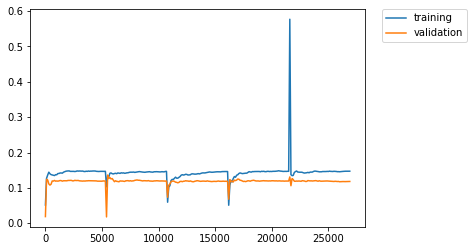


Epoch: 14
Training Loss: 0.14574
Validation Loss: 0.12016


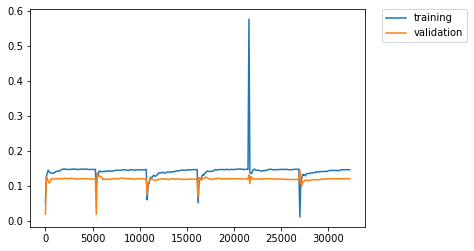


Epoch: 15
Training Loss: 0.14569
Validation Loss: 0.11861


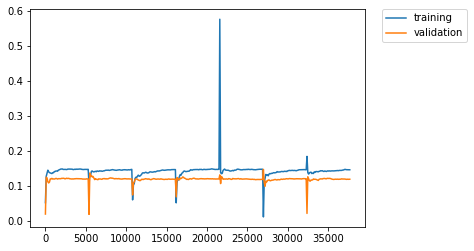


Epoch: 16
Training Loss: 0.14521
Validation Loss: 0.1176


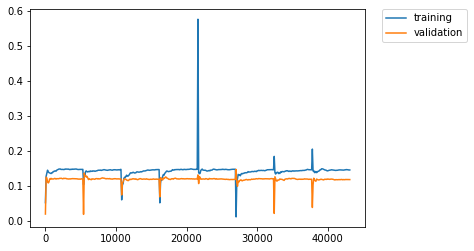


Epoch: 17
Training Loss: 0.14467
Validation Loss: 0.11729


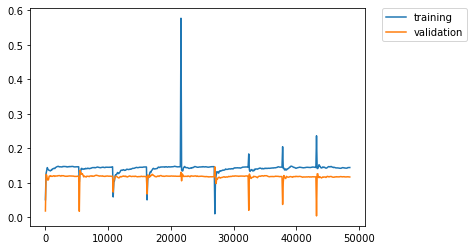


Epoch: 18
Training Loss: 0.14502
Validation Loss: 0.11714


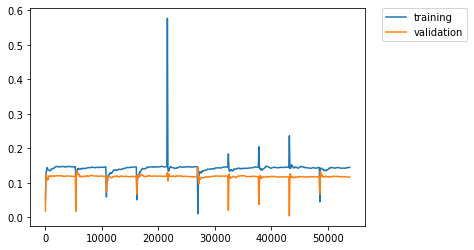

In [4]:
tester = Tester()
tester.run_training(10, "./snapshots/9_0.14807_weights.pt")

In [5]:
tester.test_accuracy()

Total: 10000
Correct: 9606
Percent Correct: 96.06%


In [6]:
# Visualize feature maps
"""
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

net.conv1.register_forward_hook(get_activation('conv1'))
net.conv2.register_forward_hook(get_activation('conv2'))
net.conv3.register_forward_hook(get_activation('conv3'))

def getActivations(name):
    act = activation[name].squeeze()
    act = act.cpu()
    act = act.detach().numpy()
    print("Convolution: "+name)
    print("Activation size: "+str(act.shape[1:]))

    nrows = 4
    ncols = 4
    
    fig, axarr = plt.subplots(nrows,ncols, figsize=(12, 4))
    for x in range(nrows):
        for y in range(ncols):
            axarr[x][y].imshow(act[ncols*x + y], cmap='gray')
    plt.show()
"""

'\nactivation = {}\ndef get_activation(name):\n    def hook(model, input, output):\n        activation[name] = output.detach()\n    return hook\n\nnet.conv1.register_forward_hook(get_activation(\'conv1\'))\nnet.conv2.register_forward_hook(get_activation(\'conv2\'))\nnet.conv3.register_forward_hook(get_activation(\'conv3\'))\n\ndef getActivations(name):\n    act = activation[name].squeeze()\n    act = act.cpu()\n    act = act.detach().numpy()\n    print("Convolution: "+name)\n    print("Activation size: "+str(act.shape[1:]))\n\n    nrows = 4\n    ncols = 4\n    \n    fig, axarr = plt.subplots(nrows,ncols, figsize=(12, 4))\n    for x in range(nrows):\n        for y in range(ncols):\n            axarr[x][y].imshow(act[ncols*x + y], cmap=\'gray\')\n    plt.show()\n'